In [2]:
%matplotlib inline
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from h5py import File
import pandas as pd
from IPython.display import Math
from scipy.special import eval_genlaguerre
import math
from math import gamma, factorial
import json, os
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from scipy.optimize import curve_fit

# Histogram experiment to characterise the readout (g or e)

100
Readout length =  3000
Readout window =  [1200, 3900]
Digital atten =  -20
Readout frequency =  7.789795


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Single shot readout fidility from channel  I  =  0.8816666666666667
Single shot readout fidility from channel  Q  =  0.6516666666666666
---------------------------
Single shot readout fidility from channel  I  after rotation =  0.9333333333333333
Optimal angle = 0.5683283124876748
0.9333333333333333
-0.015636776340012534
Single shot readout fidility from channel  Q  after rotation =  0.010666666666666666
Optimal angle = 0.5683283124876748
0.010666666666666666
-0.016928805256151876
---------------------------


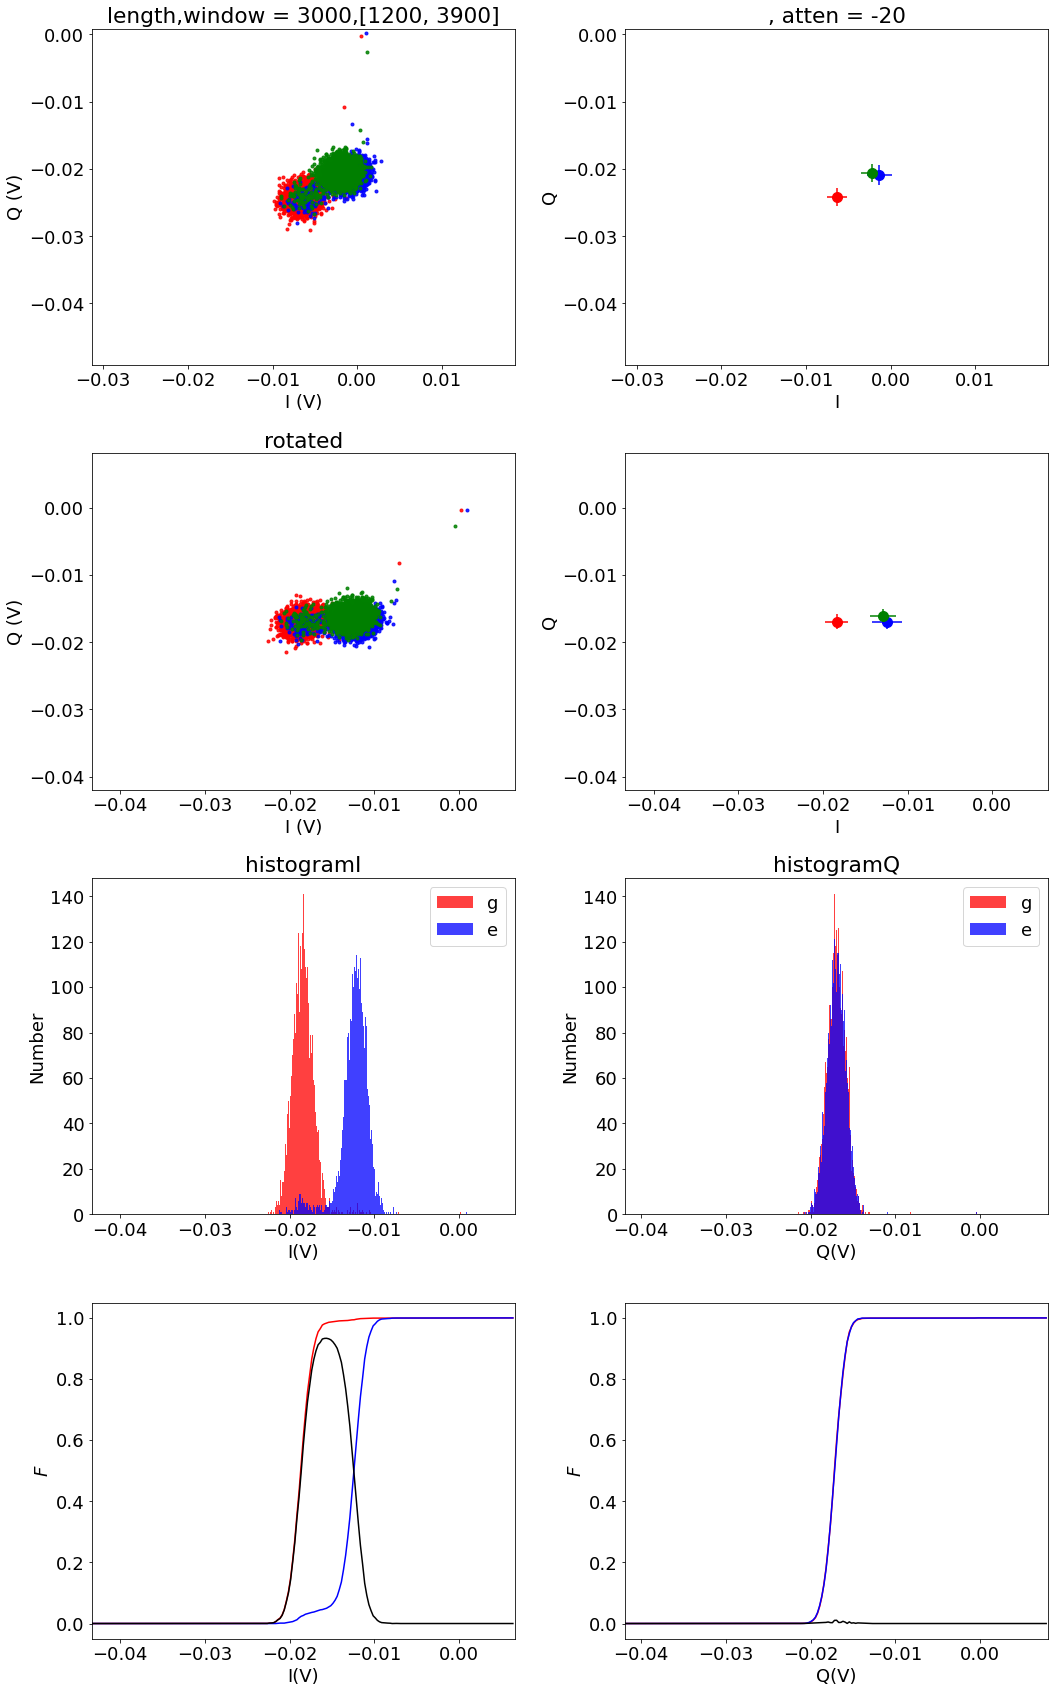

In [3]:
expt_name = 'histogram'
filelist = [162]

tags = ['','','','','','','']

rancut = 5*ones(len(filelist))
for jj,i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']

        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        numbins = expt_cfg['numbins']
        print (numbins)
        numbins = 200
        a_num = expt_cfg['acquisition_num']
        ns = expt_cfg['num_seq_sets']
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        print ('Readout length = ',readout_length)
        print ('Readout window = ',window)
        print ("Digital atten = ",atten)
        print ("Readout frequency = ",nu_r)
        I = array(a['I'])
        Q = array(a['Q'])
        sample = a_num
        
        I, Q = I/2**15*ran, Q/2**15*ran
        
        colors = ['r','b','g']
        labels= ['g','e','f']
        titles=['I','Q']

        IQs = mean(I[::3],1),mean(Q[::3],1),mean(I[1::3],1),mean(Q[1::3],1),mean(I[2::3],1),mean(Q[2::3],1)
        IQsss = I.T.flatten()[0::3],Q.T.flatten()[0::3],I.T.flatten()[1::3],Q.T.flatten()[1::3],I.T.flatten()[2::3],Q.T.flatten()[2::3]
        
        fig = plt.figure(figsize=(15, 7*5))

        ax = fig.add_subplot(621,title= 'length,window = ' + str(readout_length) + ','+str(window))
        x0g,y0g  = mean(IQsss[0][::int(a_num/sample)]),mean(IQsss[1][::int(a_num/sample)])
        x0e,y0e  = mean(IQsss[2][::int(a_num/sample)]),mean(IQsss[3][::int(a_num/sample)])
        phi = arctan((y0e-y0g)/(x0e-x0g))
        for ii in range(3):
            ax.plot(IQsss[2*ii][:],IQsss[2*ii+1][:],'.',color = colors[ii],alpha=0.85)

        ax.set_xlabel('I (V)')
        ax.set_ylabel('Q (V)') 
        ax.set_xlim(x0g-ran/rancut[jj],x0g+ran/rancut[jj])
        ax.set_ylim(y0g-ran/rancut[jj],y0g+ran/rancut[jj])
        
        

        ax = fig.add_subplot(622,title= tags[jj] + ', atten = ' + str(atten))
        
        for ii in range(3):
            ax.errorbar(mean(IQsss[2*ii]),mean(IQsss[2*ii+1]),xerr = std(IQsss[2*ii]),yerr = std(IQsss[2*ii+1]),fmt = 'o',color=colors[ii],markersize=10)
        ax.set_xlabel('I')
        ax.set_ylabel('Q')

        ax.set_xlim(x0g-ran/rancut[jj],x0g+ran/rancut[jj])
        ax.set_ylim(y0g-ran/rancut[jj],y0g+ran/rancut[jj])
        
    
        IQsssrot = (I.T.flatten()[0::3]*cos(phi) + Q.T.flatten()[0::3]*sin(phi),
                    -I.T.flatten()[0::3]*sin(phi) + Q.T.flatten()[0::3]*cos(phi),
                    I.T.flatten()[1::3]*cos(phi) + Q.T.flatten()[1::3]*sin(phi),
                            -I.T.flatten()[1::3]*sin(phi) + Q.T.flatten()[1::3]*cos(phi),
                           I.T.flatten()[2::3]*cos(phi) + Q.T.flatten()[2::3]*sin(phi),
                            -I.T.flatten()[2::3]*sin(phi) + Q.T.flatten()[2::3]*cos(phi))

        
        
        ax = fig.add_subplot(623,title= 'rotated')
        x0gr,y0gr  = mean(IQsssrot[0][:]),mean(IQsssrot[1][:])
        x0er,y0er  = mean(IQsssrot[2][:]),mean(IQsssrot[3][:])

        for ii in range(3):
            ax.plot(IQsssrot[2*ii][:],IQsssrot[2*ii+1][:],'.',color = colors[ii],alpha=0.85)

        ax.set_xlabel('I (V)')
        ax.set_ylabel('Q (V)') 
        ax.set_xlim(x0gr-ran/rancut[jj],x0gr+ran/rancut[jj])
        ax.set_ylim(y0gr-ran/rancut[jj],y0gr+ran/rancut[jj])
        
        

        ax = fig.add_subplot(624)
        
        for ii in range(3):
            ax.errorbar(mean(IQsssrot[2*ii]),mean(IQsssrot[2*ii+1]),xerr = std(IQsssrot[2*ii]),yerr = std(IQsssrot[2*ii+1]),fmt = 'o',color=colors[ii],markersize=10)
        ax.set_xlabel('I')
        ax.set_ylabel('Q')

        ax.set_xlim(x0gr-ran/rancut[jj],x0gr+ran/rancut[jj])
        ax.set_ylim(y0gr-ran/rancut[jj],y0gr+ran/rancut[jj])
        
        for kk in range(4):

            ax = fig.add_subplot(6,2,kk%2+5,title= expt_name + titles[kk%2] )
            ax.hist(IQsssrot[kk], bins=numbins ,alpha=0.75,color=colors[int(kk/2)],label = labels[int(kk/2)])
            ax.set_xlabel(titles[kk % 2] + '(V)')
            ax.set_ylabel('Number')
            ax.legend()
            if kk%2 == 0:
                ax.set_xlim(x0gr-ran/rancut[jj],x0gr+ran/rancut[jj])
            else:
                ax.set_xlim(y0gr-ran/rancut[jj],y0gr+ran/rancut[jj])
        

    
    for ii,i in enumerate(['I','Q']):
        sshg, ssbinsg = np.histogram(IQsss[ii], bins=numbins)
        sshe, ssbinse = np.histogram(IQsss[ii+2], bins=numbins)
        fid = np.abs(((np.cumsum(sshg) - np.cumsum(sshe)) / sshg.sum())).max()

        print ("Single shot readout fidility from channel ",i," = ",fid)
    print ('---------------------------')
    
    for ii,i in enumerate(['I','Q']):
        if ii is 0:lims = [x0gr-ran/rancut[jj],x0gr+ran/rancut[jj]]
        else:lims  = [y0gr-ran/rancut[jj],y0gr+ran/rancut[jj]]
        sshg, ssbinsg = np.histogram(IQsssrot[ii], bins=numbins,range =lims )
        sshe, ssbinse = np.histogram(IQsssrot[ii+2], bins=numbins,range =lims)
        fid = np.abs(((np.cumsum(sshg) - np.cumsum(sshe)) / sshg.sum())).max()

        print ("Single shot readout fidility from channel ",i," after rotation = ",fid)
        print ("Optimal angle =",phi)
    
        ax = fig.add_subplot(6,2,7+ii)
        ax.plot(ssbinse[:-1],cumsum(sshg)/sshg.sum(),color='r')
        ax.plot(ssbinse[:-1],cumsum(sshe)/sshg.sum(),color='b')
        ax.plot(ssbinse[:-1],np.abs(cumsum(sshe)-cumsum(sshg))/sshg.sum(),color='k')
        I_max = ssbinse[:-1][np.argmax(np.abs(cumsum(sshe)-cumsum(sshg))/sshg.sum())]
        print(np.max(np.abs(cumsum(sshe)-cumsum(sshg))/sshg.sum()))
        print(I_max)
        if ii == 0:
            ax.set_xlim(x0gr-ran/rancut[jj],x0gr+ran/rancut[jj])
        else:
            ax.set_xlim(y0gr-ran/rancut[jj],y0gr+ran/rancut[jj])
        ax.set_xlabel(titles[ii] + '(V)')
        ax.set_ylabel('$F$')
    print ('---------------------------')
    
    fig.tight_layout()
    plt.show()

# Use the raw (I, Q) data to assign a probability based on its distance from each blob

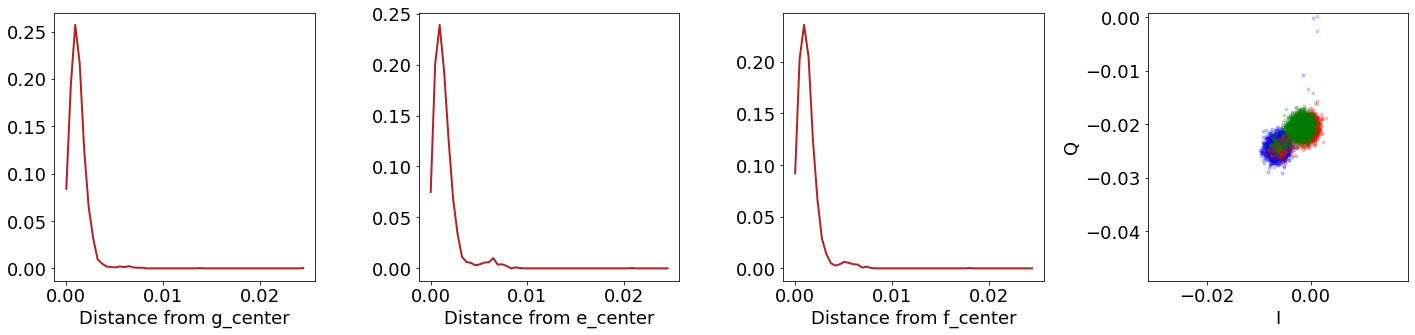

In [4]:
g_center = (median(IQsss[0]),median(IQsss[1]))
e_center = (median(IQsss[2]),median(IQsss[3]))
f_center = (median(IQsss[4]),median(IQsss[5]))

gg_radius = sqrt((IQsss[0]-g_center[0])**2 + (IQsss[1]-g_center[1])**2)
eg_radius = sqrt((IQsss[0]-e_center[0])**2 + (IQsss[1]-e_center[1])**2)
fg_radius = sqrt((IQsss[0]-f_center[0])**2 + (IQsss[1]-f_center[1])**2)

ge_radius = sqrt((IQsss[2]-g_center[0])**2 + (IQsss[3]-g_center[1])**2)
ee_radius = sqrt((IQsss[2]-e_center[0])**2 + (IQsss[3]-e_center[1])**2)
fe_radius = sqrt((IQsss[2]-f_center[0])**2 + (IQsss[3]-f_center[1])**2)

gf_radius = sqrt((IQsss[4]-g_center[0])**2 + (IQsss[5]-g_center[1])**2)
ef_radius = sqrt((IQsss[4]-e_center[0])**2 + (IQsss[5]-e_center[1])**2)
ff_radius = sqrt((IQsss[4]-f_center[0])**2 + (IQsss[5]-f_center[1])**2)

num_sigmas = 3
num_bins = int(sqrt(len(ge_radius)))+1
bins = linspace(0, max(gg_radius), num_bins)

fig, axs = plt.subplots(ncols=4, figsize = (20,5))

axs[0].set_xlabel('Distance from g_center')
counts, bin_edges = np.histogram(gg_radius, bins)
counts_g = counts/sum(counts)
bins_g = bin_edges[:-1]
axs[0].plot(bins_g, counts_g, linewidth=2, color='firebrick')

axs[1].set_xlabel('Distance from e_center')
counts, bin_edges = np.histogram(ee_radius, bins)
counts_e = counts/sum(counts)
bins_e = bin_edges[:-1]
axs[1].plot(bins_e, counts_e, linewidth=2, color='firebrick')

axs[2].set_xlabel('Distance from f_center')
counts, bin_edges = np.histogram(ff_radius, bins)
counts_f = counts/sum(counts)
bins_f = bin_edges[:-1]
axs[2].plot(bins_f, counts_f, linewidth=2, color='firebrick')

centers = [g_center,e_center,f_center]
# distributions = [gauss_g, gauss_e, gauss_f]
counts = [counts_g, counts_e, counts_f]
# max_radius = [max_gg_radius,max_ee_radius,max_ff_radius]
bins = bins[:-1]

colors = ['b', 'r', 'g']
for ii in [0,1,2]:
    axs[3].plot(IQsss[2*ii][::int(a_num/sample)],IQsss[2*ii+1][::int(a_num/sample)],'.',color = colors[ii],alpha=0.2)
axs[3].set_xlim(x0g-ran/rancut[0],x0g+ran/rancut[0])
axs[3].set_ylim(y0g-ran/rancut[0],y0g+ran/rancut[0])

axs[3].set_xlabel('I')
axs[3].set_ylabel('Q')
plt.tight_layout()
plt.show()

## Computing (assigning) the fidelities for g and e

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


g fidelity: 0.981 pm 0.003
e fidelity: 0.988 pm 0.004


<function matplotlib.pyplot.show(*args, **kw)>

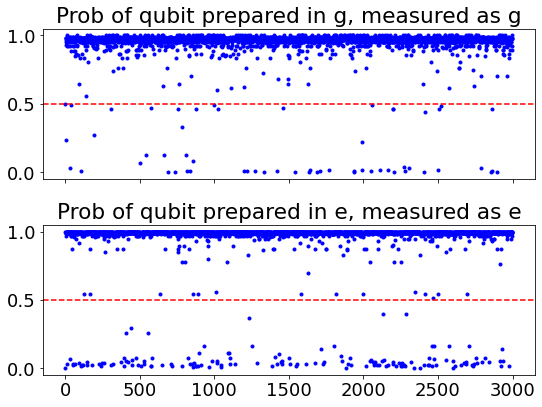

In [5]:
g_I = IQsss[0]
g_Q = IQsss[1]
e_I = IQsss[2]
e_Q = IQsss[3]
# f_I = IQsss[4]
# f_Q = IQsss[5]

g_qubit_state_prob_counts = []
e_qubit_state_prob_counts = []
# f_qubit_state_prob_counts = []
for jj in range(len(g_I)):
    g_probs_counts = []
    e_probs_counts = []
#     f_probs_counts = []
    for ii in range(len(centers[0:2])):
            dist = sqrt((g_I[jj]-centers[ii][0])**2 + (g_Q[jj]-centers[ii][1])**2)
            dist_index = argmin(abs(bins-dist))
            g_probs_counts.append(counts[ii][dist_index])
            
            dist = sqrt((e_I[jj]-centers[ii][0])**2 + (e_Q[jj]-centers[ii][1])**2)
            dist_index = argmin(abs(bins-dist))
            e_probs_counts.append(counts[ii][dist_index])
            
#             dist = sqrt((f_I[jj]-centers[ii][0])**2 + (f_Q[jj]-centers[ii][1])**2)
#             dist_index = argmin(abs(bins-dist))
#             f_probs_counts.append(counts[ii][dist_index])
            
    g_probs_counts = g_probs_counts/sum(g_probs_counts)
    g_qubit_state_prob_counts.append(g_probs_counts)
    
    e_probs_counts = e_probs_counts/sum(e_probs_counts)
    e_qubit_state_prob_counts.append(e_probs_counts)
    
#     f_probs_counts = f_probs_counts/sum(f_probs_counts)
#     f_qubit_state_prob_counts.append(f_probs_counts)

g_state_prob_list = asarray(g_qubit_state_prob_counts).T[0]
e_state_prob_list = asarray(e_qubit_state_prob_counts).T[1]
# f_state_prob_list = asarray(f_qubit_state_prob_counts).T[2]


g_counter = 0
e_counter = 0
# f_counter = 0
readout_thresh = 1/2
for ii in range(len(g_state_prob_list)):
    if g_state_prob_list[ii] <= readout_thresh:
        g_counter = g_counter + 1
    if e_state_prob_list[ii] <= readout_thresh:
        e_counter = e_counter + 1
#     if f_state_prob_list[ii] <= readout_thresh:
#         f_counter = f_counter + 1

Pge = 0.01*(1-exp(-3/79))
Peg = 1-exp(-3/79)

# Pge=0
# Peg=0

g_inf = g_counter/len(g_state_prob_list) - Pge
e_inf = e_counter/len(e_state_prob_list) - Peg
# f_inf = f_counter/len(f_state_prob_list)

g_inf_err = sqrt(g_counter)/len(g_state_prob_list)
e_inf_err = sqrt(e_counter)/len(e_state_prob_list)
# f_inf_err = sqrt(f_counter)/len(f_state_prob_list)
        
print ("g fidelity: %.3f pm %.3f" %(1-g_inf, g_inf_err))
print ("e fidelity: %.3f pm %.3f" %(1-e_inf, e_inf_err))
# print ("f fidelity: %.3f pm %.3f" %(1-f_inf, f_inf_err))

fig, axs = plt.subplots(nrows=2, figsize = (8,6), sharex=True)
axs[0].plot(g_state_prob_list, 'b.')
axs[0].axhline(readout_thresh, linestyle='--', color='red')
axs[0].set_title("Prob of qubit prepared in g, measured as g")

axs[1].plot(e_state_prob_list, 'b.')
axs[1].axhline(readout_thresh, linestyle='--', color='red')
axs[1].set_title("Prob of qubit prepared in e, measured as e")
plt.tight_layout()
plt.show

# g3 pulse1

Number of events collected : 1500
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


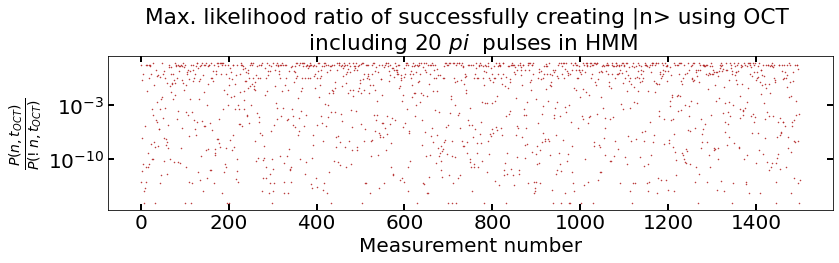

In [63]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [4]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g0_new\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 11
    stop = start + 20
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
#     for ii in range (len(meas_sequence)):
    temp_meas_sequence = meas_sequence
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
    P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-3, 1.5)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [64]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.26


100


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


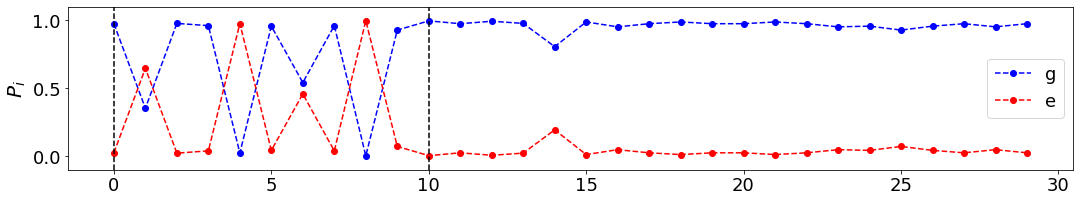

101


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

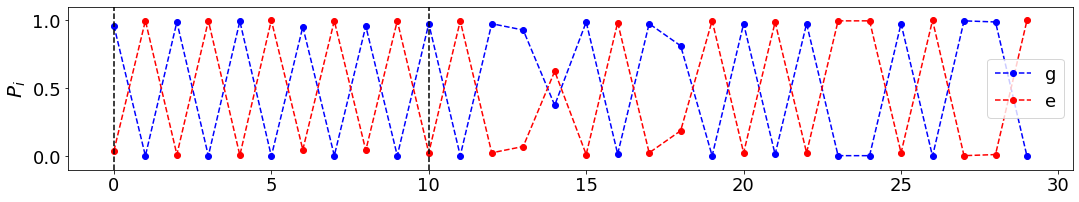

102


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

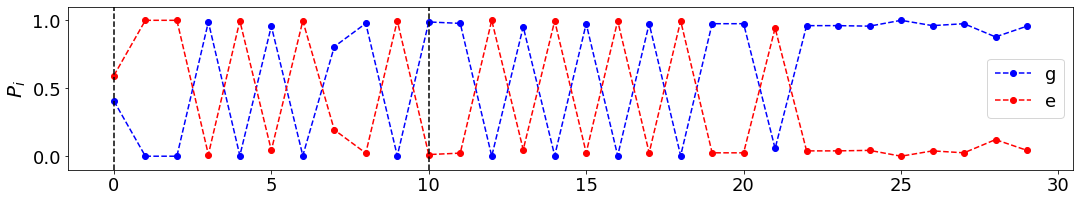

103


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

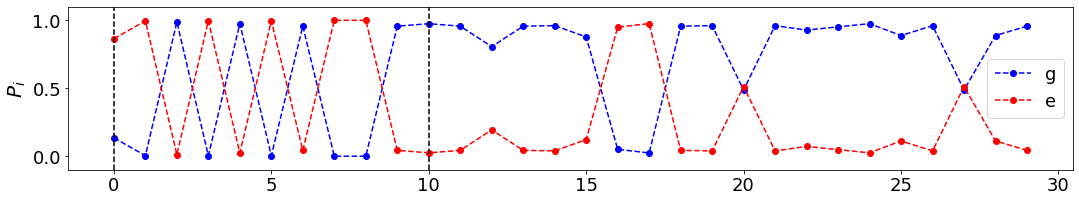

104


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

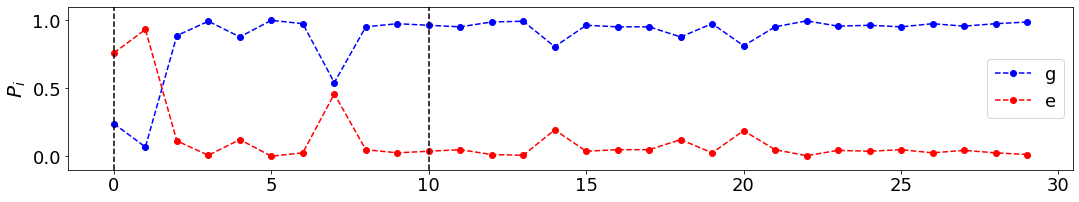

105


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

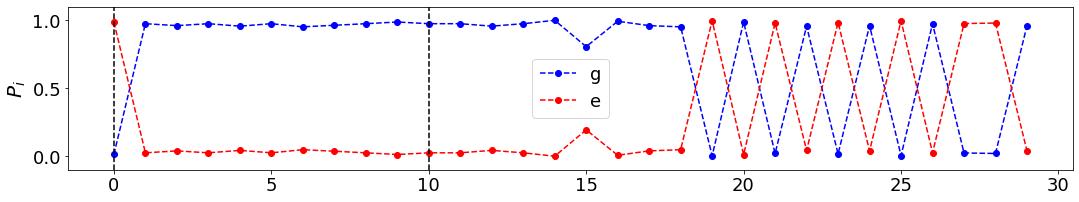

106


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

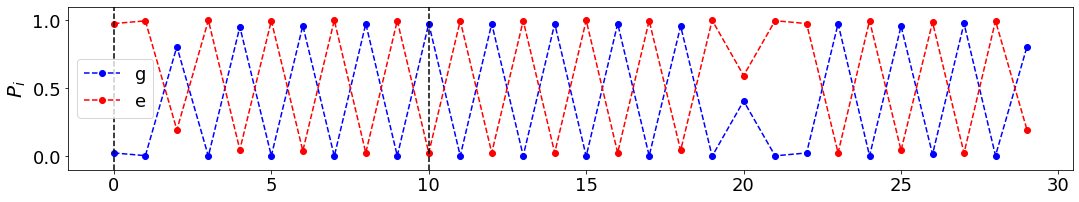

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


107


<Figure size 432x288 with 0 Axes>

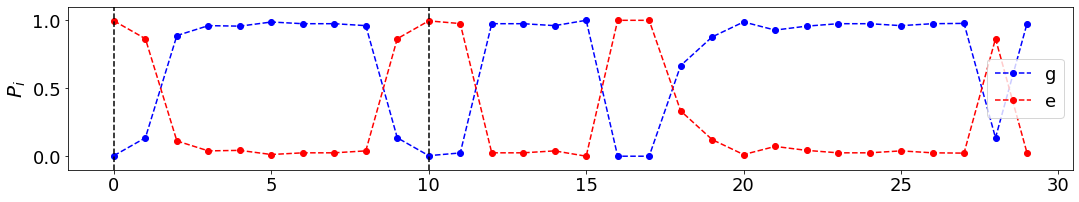

108


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

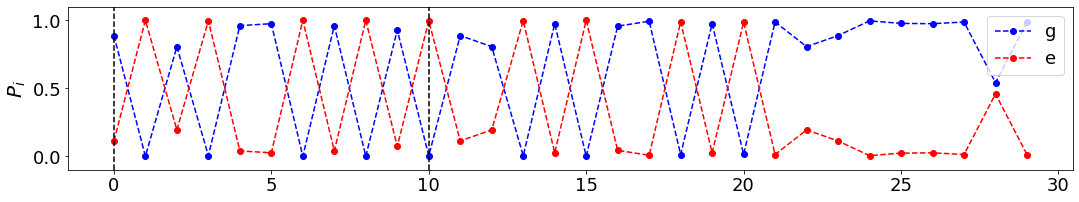

109


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

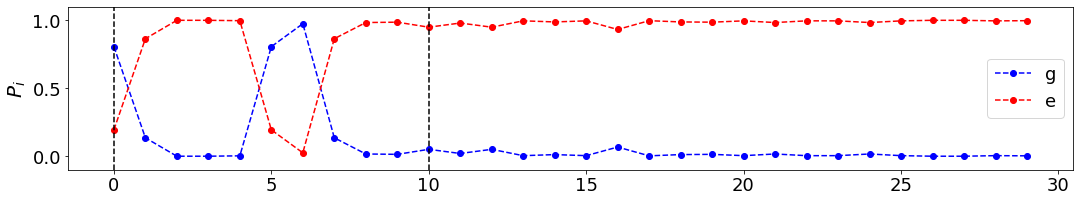

<Figure size 432x288 with 0 Axes>

In [56]:
start = 9
stop = -1
n = 10
s = 100
for kk in range(n):
    print(s+kk)
    i = Is[s+kk]
    q = Qs[s+kk]
    qubit_state_prob_counts = []
    for jj in range(len(i)):
        x = 0
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i[jj]-centers[ii][0])**2 + (q[jj]-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)
        
    fig, axs = plt.subplots(figsize=(18, 3))
    axs.plot(asarray(qubit_state_prob_counts).T[0][start:stop],'bo--', label='g')
    axs.plot(asarray(qubit_state_prob_counts).T[1][start:stop],'ro--', label='e')
    axs.set_ylabel('$P_{i}$', fontsize=20)
    axs.set_ylim(-0.1,1.1)
    axs.axvline(x=0, linestyle='--', color='k')
    axs.axvline(x=10, linestyle='--', color='k')

    axs.legend(loc='best')
    plt.show()
    plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.019594402760446106


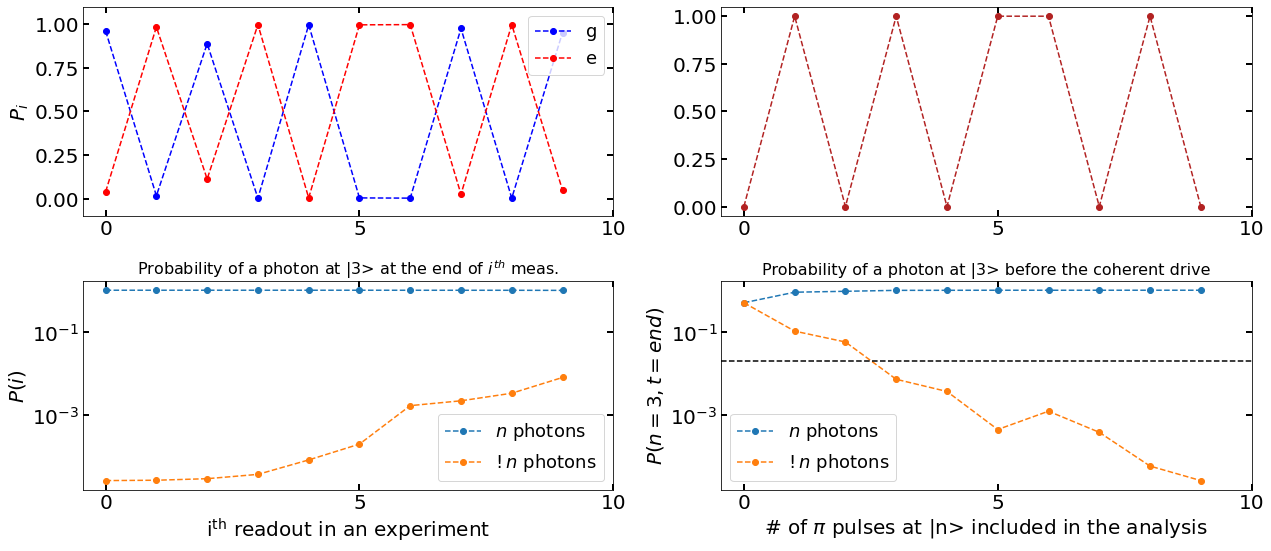

In [30]:
i = Is[108]
q = Qs[108]

qubit_state_prob_counts = []
for jj in range(len(i)):
    probs_counts = []
    for ii in range(len(centers[0:2])):
            dist = sqrt((i[jj]-centers[ii][0])**2 + (q[jj]-centers[ii][1])**2)
            dist_index = argmin(abs(bins-dist))
            probs_counts.append(counts[ii][dist_index])
    probs_counts = probs_counts/sum(probs_counts)
    qubit_state_prob_counts.append(probs_counts)

start = 9
stop = start + 10 

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(18,8))
axs[0][0].plot(asarray(qubit_state_prob_counts).T[0][start:stop],'bo--', label='g')
axs[0][0].plot(asarray(qubit_state_prob_counts).T[1][start:stop],'ro--', label='e')
axs[0][0].set_ylabel('$P_{i}$', fontsize=20)
axs[0][0].set_xticks(np.linspace(0, stop-start, (stop-start)//5+1))
axs[0][0].set_ylim(-0.1,1.1)
axs[0][0].legend(loc='best')
axs[0][0].tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)

meas_sequence = []
g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]

for ii in range (len(g_state_prob_list)):
    if g_state_prob_list[ii]>0.5:
        meas_sequence.append(0)
    elif e_state_prob_list[ii]>0.5:
        meas_sequence.append(1)
    else:
        if ii == 0:
            meas_sequence.append(0)
        else:
            meas_sequence.append(meas_sequence[ii-1])
axs[0][1].plot(meas_sequence, 'o--',color='firebrick')
axs[0][1].set_xticks(np.linspace(0, stop-start, (stop-start)//5+1))
axs[0][1].tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)

"""HMM Matrices for initial Fock state preparation. All the timescales are in us"""
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

# multimode_params = {"Ej":24.428,"Ec":0.13537, "N":150, "nus":[nu_r-0.0064, nu_cavs[mode]-0.00305], "gs":[0.09602, 0.04318],\
#                     "T1s":[79e3, 300, 2e6], "nths":[0.01, 0.001, 0.001],"truncation":[nq, nr, nm],"amp_cal":[0.1, 1.0]}

P01 = cav_n * (1-exp(-trigger_period/cav_t1))
P10 = 1-exp(-trigger_period/cav_t1)
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = 0.5*asarray([[(1-P01)*(1-Pge), (1-P01)*Pge, P01*Pge, P01*(1-Pge)],
     [(1-P01)*Peg, (1-P01)*(1-Peg), P01*(1-Peg), P01*Peg],
     [P10*(1-Pge), P10*Pge, (1-P10)*Pge, (1-P10)*(1-Pge)],
     [P10*Peg, P10*(1-Peg), (1-P10)*(1-Peg), (1-P10)*Peg]])

E = asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])


"""Computing probability at the end of measurement at |n>"""
gamma_matrix = gamma(meas_sequence, T, E)
P0 = gamma_matrix[:,0] + gamma_matrix[:,1]
P1 = gamma_matrix[:,2] + gamma_matrix[:,3]


"""Computing probability at the end of measurement at |n> with varying number of pi pulses included in the analysis"""
P0_last = []
P1_last = []
for ii in range (len(meas_sequence)):
    temp_meas_sequence = meas_sequence[0:ii+1]
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_last.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_last.append(gamma_matrix[0,2] + gamma_matrix[0,3])

axs[1][0].semilogy(P1, 'o--', label= "$n$ photons")
axs[1][0].semilogy(P0, 'o--', label= "$!n$ photons")
axs[1][0].set_title('Probability of a photon at |%.f> at the end of $i^{th}$ meas.'%fstate_in, fontsize=16)
axs[1][0].set_ylabel(r'$P(i)$', fontsize=20)
axs[1][0].set_xlabel('$\mathrm{i^{th}}$ readout in an experiment', fontsize=20)
axs[1][0].set_xticks(np.linspace(0, stop-start, (stop-start)//5+1))
axs[1][0].legend(loc='best')
axs[1][0].tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)

cav_lifetime_err = 1-np.exp(-trigger_period/cav_t1)
print(cav_lifetime_err)
axs[1][1].semilogy(P1_last, 'o--', label= "$n$ photons")
axs[1][1].semilogy(P0_last, 'o--', label= "$!n$ photons")
axs[1][1].set_title('Probability of a photon at |%.f> before the coherent drive'%fstate_in, fontsize=16)
axs[1][1].axhline(y = cav_lifetime_err, linestyle='--', color = 'k')
axs[1][1].set_ylabel(r'$P(n=%.f, t=end)$'%fstate_in, fontsize=20)
axs[1][1].set_xticks(np.linspace(0, stop-start, (stop-start)//5+1))
axs[1][1].set_xlabel('# of $\pi$ pulses at |n> included in the analysis', fontsize=20)
axs[1][1].legend(loc='best')
axs[1][1].tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

# g0 with cavity_amp = 0.008, length = 275 ns

Number of events collected : 1000
data/g3/oct_pulses/00000_g0_to_g3_mode_mm_2_2.0us_qamp_7.5_camp_0.2_gamp_0.1_dwdt_0.1_dw2dt2_0.01.h5
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


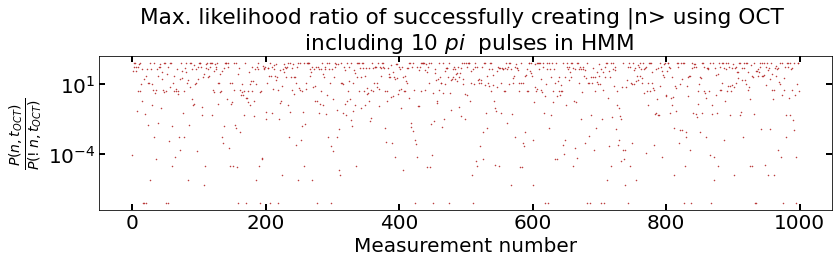

In [66]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [1]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g3\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
print(expt_cfg['filename'])
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + 10
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
        P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-3, 1.5)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [55]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.35


# g0 with cavity_amp = 0.009, length = 275 ns

Number of events collected : 1000
data/g3/oct_pulses/00000_g0_to_g3_mode_mm_2_2.0us_qamp_7.5_camp_0.2_gamp_0.1_dwdt_1.0_dw2dt2_0.1.h5
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


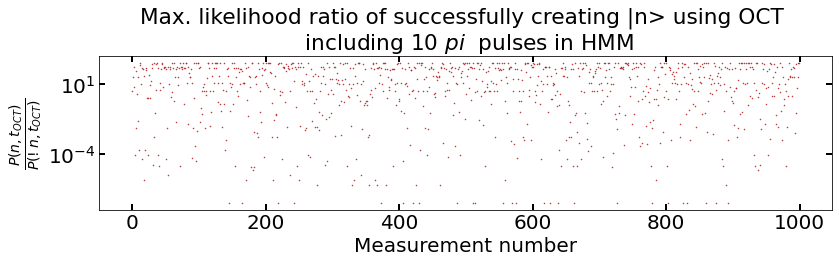

In [67]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [2]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g3\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
print(expt_cfg['filename'])
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + 10
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
        P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [68]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.35


# g0 with cavity_amp = 0.01, length = 275 ns

Number of events collected : 1000
data/g3/oct_pulses/00000_g0_to_g3_mode_mm_2_2.0us_qamp_7.5_camp_0.2_gamp_0.2_dwdt_1.0_dw2dt2_0.1.h5
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


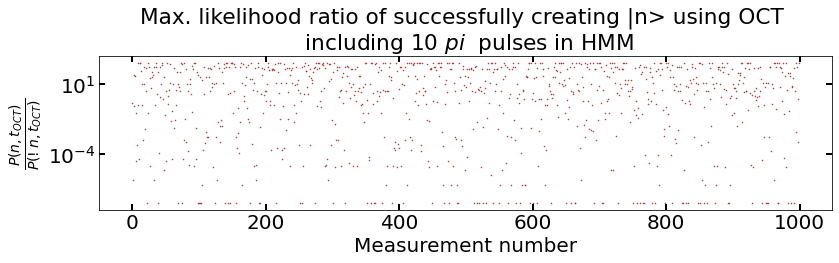

In [73]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [3]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g3\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
print(expt_cfg['filename'])
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
# trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + 10
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
        P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [74]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.29


# g0 with cavity_amp = 0.011, length = 275 ns

Number of events collected : 1000
data/g3/oct_pulses/00001_g0_to_g3_mode_mm_2_2.0us_qamp_7.5_camp_0.4_gamp_0.0001_dwdt_1.0_dw2dt2_0.1.h5
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


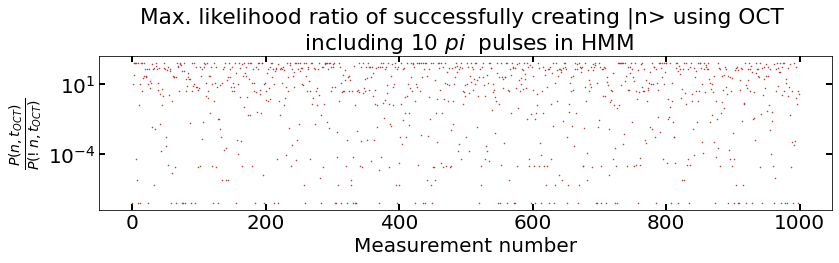

In [82]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [4]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g3\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
print(expt_cfg['filename'])
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + 10
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
        P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [83]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.32


# g0 with cavity_amp = 0.012, length = 275 ns

Number of events collected : 1000
oct_pulses/g3.h5
10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.0367558  0.00243301 0.1217356  1.8390756 ]
 [0.00701794 0.03217086 1.60966858 0.35114262]]
[[0.48268631 0.01731369]
 [0.00736866 0.49263134]
 [0.48268631 0.01731369]
 [0.00736866 0.49263134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


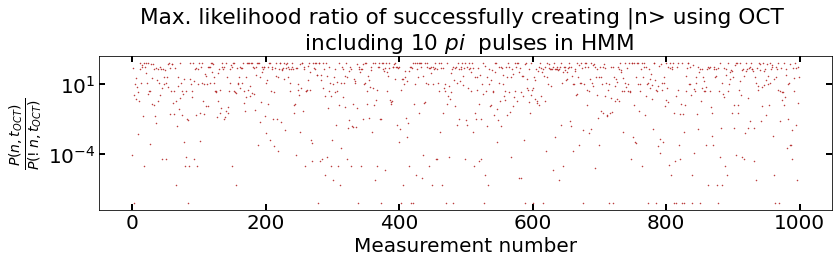

In [94]:
expt_name = 'sequential_optimal_control_repeated_pi_pulses'
filelist = [5]
Is = []
Qs = []

for ii,i in enumerate(filelist):
    filename = "..\\data\\g3\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
print(expt_cfg['filename'])
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + 10
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
        P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [95]:
df1 = pd.DataFrame({'pn':p_n_oct})
Index_label1 = df1[df1['pn']>1e2].index.tolist()

print("State prep efficiency: %.2f"%(len(Index_label1)/len(df1)))

State prep efficiency: 0.35


#  g0 with cavity_amp = 0.013, length = 275 ns

Number of events collected : 6000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


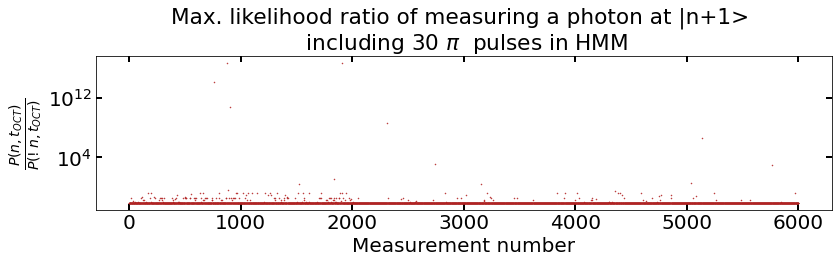

In [192]:
data_path = "../data/g0_nopiat0/camp_0.013/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [193]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

6
0.001


In [194]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

#  g0 with cavity_amp = 0.015, length = 275 ns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


Number of events collected : 477
10
[[1.87583139e+00 1.24168608e-01 0.00000000e+00 0.00000000e+00]
 [3.58160559e-01 1.64183944e+00 0.00000000e+00 0.00000000e+00]
 [2.81228784e-02 1.86156319e-03 1.22307045e-01 1.84770851e+00]
 [5.36962219e-03 2.46148194e-02 1.61722462e+00 3.52790937e-01]]
[[0.4882981  0.0117019 ]
 [0.00236866 0.49763134]
 [0.4882981  0.0117019 ]
 [0.00236866 0.49763134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:176: RuntimeWarning: invalid value encountered in true_divide


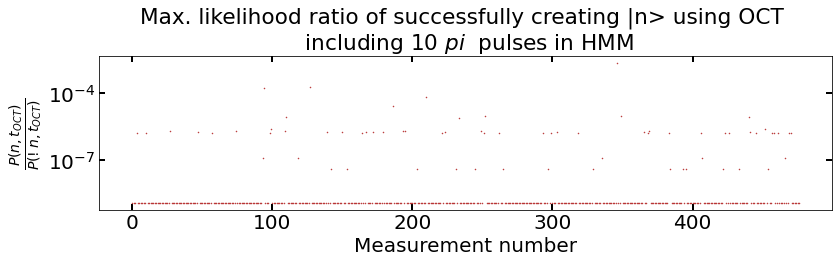

10
[[1.87583139 0.12416861 0.         0.        ]
 [0.35816056 1.64183944 0.         0.        ]
 [0.03740316 0.00247586 0.12169275 1.83842823]
 [0.00714155 0.03273748 1.60910196 0.35101901]]
[[0.4882981  0.0117019 ]
 [0.00236866 0.49763134]
 [0.4882981  0.0117019 ]
 [0.00236866 0.49763134]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:257: RuntimeWarning: invalid value encountered in true_divide


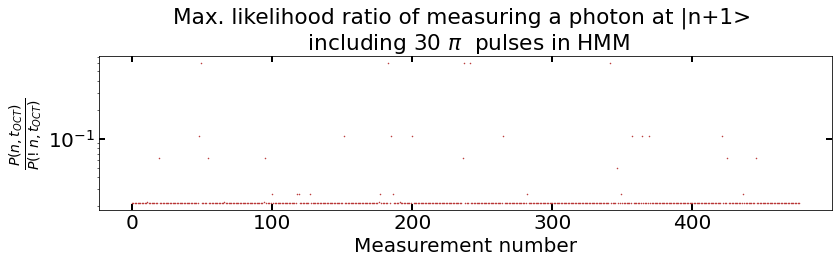

In [9]:
# --------------------------------------------
expt_name = 'histogram'
filelist = [59]
c_t1 = 1986
for jj, i in enumerate(filelist):
    filename = "..\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        numbins = expt_cfg['numbins']
        numbins = 200
        a_num = expt_cfg['acquisition_num']
        ns = expt_cfg['num_seq_sets']
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        Ih = array(a['I'])
        Qh = array(a['Q'])
        sample = a_num
        Ih, Qh = pd.DataFrame(Ih/2**15*ran), pd.DataFrame(Qh/2**15*ran)

ig, qg = Ih.iloc[0], Qh.iloc[0]
ie, qe = Ih.iloc[1], Qh.iloc[1]

xg, yg = median(ig), median(qg)
xe, ye = median(ie), median(qe)

gg_radius = sqrt((ig-xg)**2 + (qg-yg)**2)
eg_radius = sqrt((ig-xe)**2 + (qg-ye)**2)

ge_radius = sqrt((ie-xg)**2 + (qe-yg)**2)
ee_radius = sqrt((ie-xe)**2 + (qe-ye)**2)

num_sigmas = 2
num_bins = int(sqrt(len(gg_radius)))+1
bins = linspace(0, max(gg_radius), num_bins)

counts, bin_edges = np.histogram(gg_radius, bins)
counts_g = counts/sum(counts)
bins_g = bin_edges[:-1]

counts, bin_edges = np.histogram(ee_radius, bins)
counts_e = counts/sum(counts)
bins_e = bin_edges[:-1]

centers = [[xg, yg],[xe, ye]]
counts = [counts_g, counts_e]
bins = bins[:-1]

g_I = ig
g_Q = qg
e_I = ie
e_Q = qe

g_qubit_state_prob_counts = []
e_qubit_state_prob_counts = []
for jj in range(len(g_I)):
    g_probs_counts = []
    e_probs_counts = []
    for ii in range(len(centers)):
        dist = sqrt((g_I[jj]-centers[ii][0])**2 + (g_Q[jj]-centers[ii][1])**2)
        dist_index = argmin(abs(bins-dist))
        g_probs_counts.append(counts[ii][dist_index])
        
        dist = sqrt((e_I[jj]-centers[ii][0])**2 + (e_Q[jj]-centers[ii][1])**2)
        dist_index = argmin(abs(bins-dist))
        e_probs_counts.append(counts[ii][dist_index])
            
    g_probs_counts = g_probs_counts/sum(g_probs_counts)
    g_qubit_state_prob_counts.append(g_probs_counts)
    
    e_probs_counts = e_probs_counts/sum(e_probs_counts)
    e_qubit_state_prob_counts.append(e_probs_counts)

g_state_prob_list = asarray(g_qubit_state_prob_counts).T[0]
e_state_prob_list = asarray(e_qubit_state_prob_counts).T[1]

g_counter = 0
e_counter = 0
readout_thresh = 1/2
for ii in range(len(g_state_prob_list)):
    if g_state_prob_list[ii] <= readout_thresh:
        g_counter = g_counter + 1
    if e_state_prob_list[ii] <= readout_thresh:
        e_counter = e_counter + 1

Pge = 0.016*(1-exp(-3.0/79))
Peg = 1-exp(-3.0/79)

g_inf = g_counter/len(g_state_prob_list) - Pge
e_inf = e_counter/len(e_state_prob_list) - Peg

g_inf_err = sqrt(g_counter)/len(g_state_prob_list)
e_inf_err = sqrt(e_counter)/len(e_state_prob_list)
#---------------------------------------------------
data_path = "../data//g3/camp_0.015_275//"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames[:]):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# ##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = c_t1/fstate_in
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_in == 0:
    Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))
else:
    Pnm =  1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
#---------------------------------------------------
p_n_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers)):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9
    stop = start + npi_at_n
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    temp_meas_sequence = meas_sequence
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
    P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
    p_n_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = c_t1/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

print (trig_period)
print(2*T)
print(E)
##----------------------------------------------------------------##
p_m_oct = []
for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers)):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 9 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    temp_meas_sequence = meas_sequence
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [10]:
x = []
for ii, p in enumerate(p_n_oct):
    if p > 1e2:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_n_oct:
    if ii > 1e2:
        count_n+=1
print(count_n/len(p_n_oct))

0
0.0


In [197]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.018, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


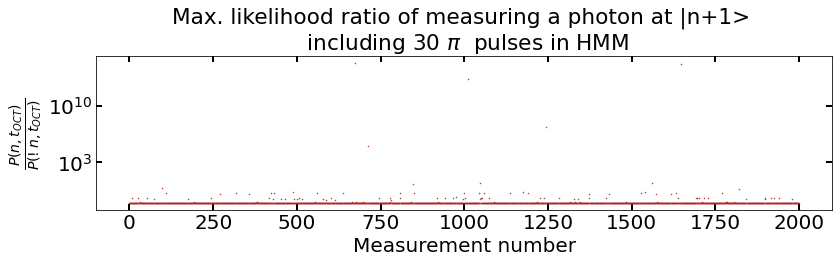

In [76]:
data_path = "../data/g0_nopiat0/camp_0.018/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [77]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

4
0.002


In [78]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.02, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


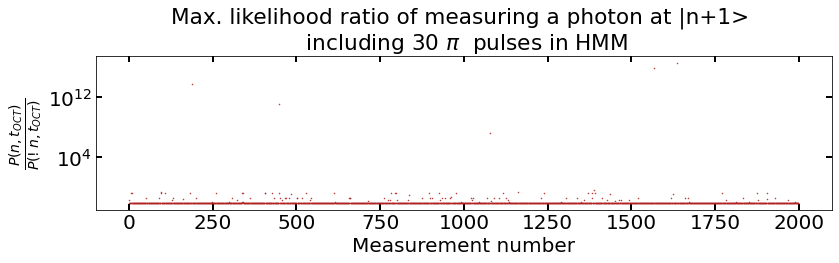

In [24]:
data_path = "../data/g0_nopiat0/camp_0.02/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [25]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

5
0.0025


In [26]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.025, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


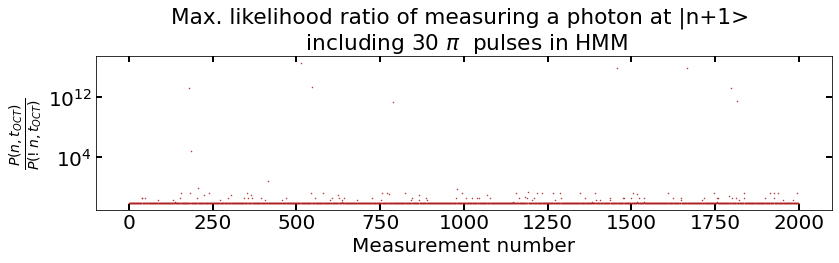

In [41]:
data_path = "../data/g0_nopiat0/camp_0.025/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [42]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

8
0.004


In [44]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.035, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


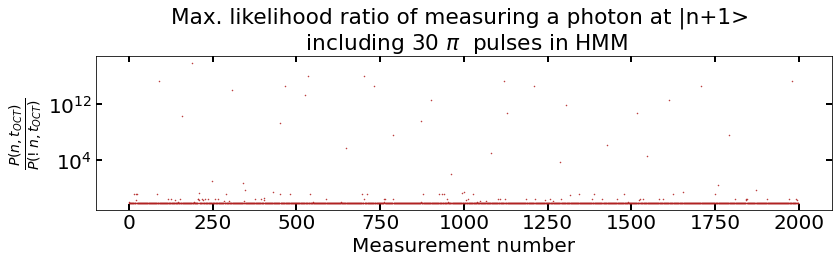

In [30]:
data_path = "../data/g0_nopiat0/camp_0.035/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [31]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

23
0.0115


In [32]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.05, length =275ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


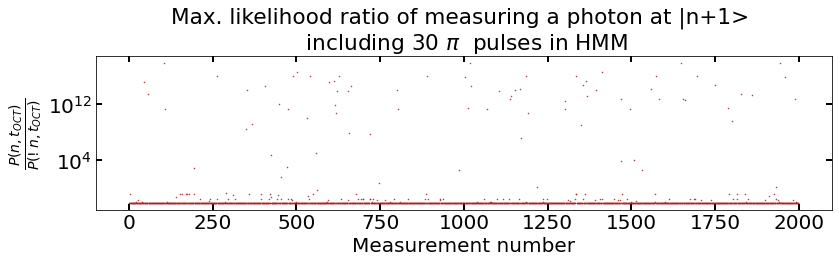

In [45]:
data_path = "../data/g0_nopiat0/camp_0.05/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [46]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

67
0.0335


In [47]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.06, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


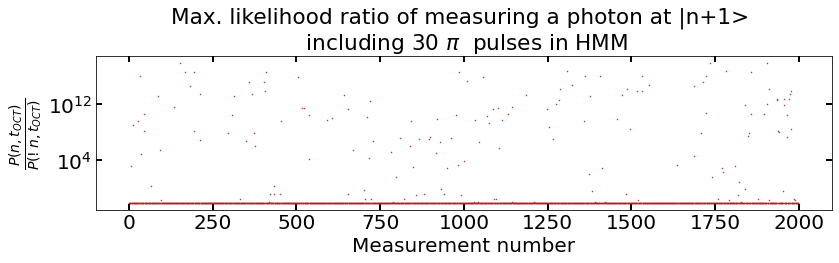

In [182]:
data_path = "../data/g0_nopiat0/camp_0.06/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [183]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

107
0.0535


In [184]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.07, length = 275ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


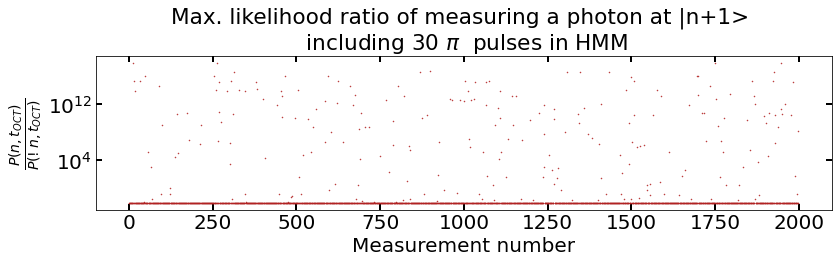

In [170]:
data_path = "../data/g0_nopiat0/camp_0.07/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [171]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

146
0.073


In [172]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
#     dset = f.create_dataset("p_n_oct", data=p_n_oct)
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.08, length = 275ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


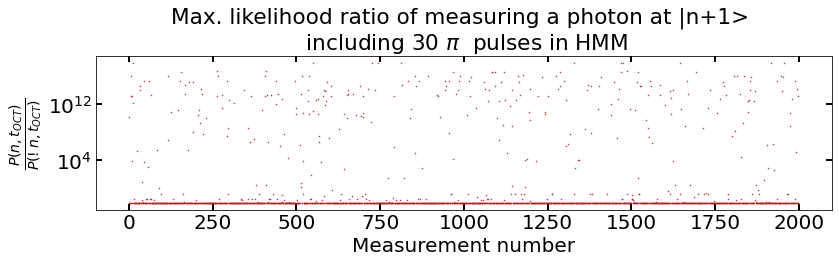

In [19]:
data_path = "../data/g0_nopiat0/camp_0.08/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [15]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

250
0.125


In [20]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# g0 with cavity_amp = 0.1, length = 275 ns

Number of events collected : 2000


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in true_divide


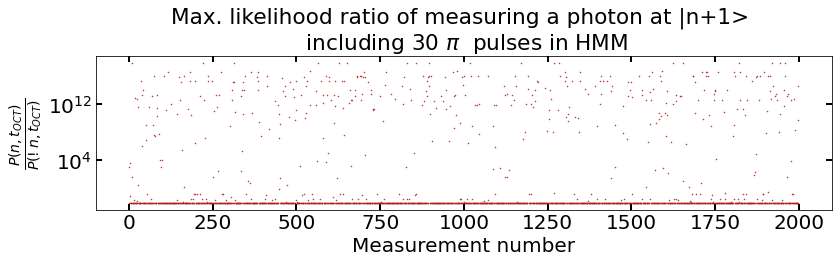

In [16]:
data_path = "../data/g0_nopiat0/camp_0.1/"
filenames = os.listdir(data_path)
Is = []
Qs = []
for ii, filename in enumerate(filenames):
    filename = data_path+'\\'+filename
    with File(filename,'r') as a:
        hardware_cfg =  (json.loads(a.attrs['hardware_cfg']))
        experiment_cfg =  (json.loads(a.attrs['experiment_cfg']))
        quantum_device_cfg =  (json.loads(a.attrs['quantum_device_cfg']))
        ran = hardware_cfg['awg_info']['keysight_pxi']['m3102_vpp_range']
        expt_cfg = (json.loads(a.attrs['experiment_cfg']))['optimal_control_repeated_pi_pulses']
        swp_cfg = (json.loads(a.attrs['experiment_cfg']))[expt_name.lower()]
        trigger_period = hardware_cfg['trigger']['period_us']
        fstate_in = int(expt_cfg['pi_at_n'])
        fstate_end = int(expt_cfg['pi_at_m'])
        npi_at_n = int(expt_cfg['num_pi_pulses_at_n'])
        npi_at_m = int(expt_cfg['num_pi_pulses_at_m'])        
        readout_length = quantum_device_cfg['readout']['length']
        window = quantum_device_cfg['readout']['window']
        atten = quantum_device_cfg['readout']['dig_atten']
        nu_r = quantum_device_cfg['readout']['freq']
        I = array(a['I'])
        Q = array(a['Q'])
        I, Q = I/2**15*ran, Q/2**15*ran
        for i, q, in zip(I, Q):
            Is.append(i)
            Qs.append(q)
print("Number of events collected : %d"%len(Is))
# --------------------------------------------
def forward(meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha
    
def backward(meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  forward(meas_seq, T, E)[-1].sum()
    
def gamma(meas_seq,T,E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha,beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    
# ##----------------------------------------------------------------##
# #all in us
# # trig_period = (trigger_period)
# parity_time = 3.6
# cav_t1 = 1516
# qubit_t1 = 79
# qubit_t2 = 58
# # cav_n = 7.3e-4
# cav_n= 0.0
# qubit_n = 1.6e-2
# g_infidelity = g_inf
# e_infidelity = e_inf

# if fstate_in == 0:
#     Pnm =  cav_n * (1-exp(-trigger_period/cav_t1))

# Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
# Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
# Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

# T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
#      [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
#      [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
#      [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

# E = 0.5*asarray([[1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity],
#     [1-g_infidelity, g_infidelity],
#     [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
# ##----------------------------------------------------------------##
# p_n_oct = []
# for I, Q in zip(Is, Qs):
#     qubit_state_prob_counts = []
    
#     for i, q in zip(I, Q):
#         probs_counts = []
#         for ii in range(len(centers[0:2])):
#                 dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
#                 dist_index = argmin(abs(bins-dist))
#                 probs_counts.append(counts[ii][dist_index])
#         probs_counts = probs_counts/sum(probs_counts)
#         qubit_state_prob_counts.append(probs_counts)

#     start = 9
#     stop = start + npi_at_n
#     meas_sequence = []
#     g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
#     e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
#     for ii in range (len(g_state_prob_list)):
#         if g_state_prob_list[ii]>0.5:
#             meas_sequence.append(0)
#         elif e_state_prob_list[ii]>0.5:
#             meas_sequence.append(1)
#         else:
#             if ii == 0:
#                 meas_sequence.append(0)
#             else:
#                 meas_sequence.append(meas_sequence[ii-1])
#     P0_first = []
#     P1_first = []
#     for ii in range (len(meas_sequence)):
#         temp_meas_sequence = meas_sequence[0:ii+1]
#         gamma_matrix = gamma(temp_meas_sequence, T, E)
#         P0_first.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
#         P1_first.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])    
#     p_n_oct.append(P1_first[-1]/P0_first[-1])

# plt.figure(figsize=(12,4))     
# plt.semilogy(p_n_oct, 'o', markersize=0.5, color='firebrick')
# plt.title('Max. likelihood ratio of successfully creating |n> using OCT \n including %.f $pi$  pulses in HMM'%(stop-start))
# plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
# plt.xlabel('Measurement number', fontsize=20)
# # plt.ylim(1e-3, 1.5)
# # plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
# plt.tick_params(direction='in', length=6, width=2, colors='k', \
#         grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
# plt.tight_layout()
# plt.show()

#--------------------------------------------------------------------------------#
##----------------------------------------------------------------##
#all in us
trig_period = (trigger_period)
parity_time = 3.6
cav_t1 = 1516/fstate_end
qubit_t1 = 79
qubit_t2 = 58
# cav_n = 7.3e-4
cav_n= 0.0
qubit_n = 1.6e-2
g_infidelity = g_inf
e_infidelity = e_inf

if fstate_end != 0:
    Pnm = 1-exp(-trigger_period/cav_t1) + cav_n * (1-exp(-trigger_period/cav_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))
Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

# print (trig_period)
# print(2*T)
# print(E)
##----------------------------------------------------------------##
p_m_oct = []

for I, Q in zip(Is, Qs):
    qubit_state_prob_counts = []
    
    for i, q in zip(I, Q):
        probs_counts = []
        for ii in range(len(centers[0:2])):
                dist = sqrt((i-centers[ii][0])**2 + (q-centers[ii][1])**2)
                dist_index = argmin(abs(bins-dist))
                probs_counts.append(counts[ii][dist_index])
        probs_counts = probs_counts/sum(probs_counts)
        qubit_state_prob_counts.append(probs_counts)

    start = 10 + npi_at_n
    stop = -1
    meas_sequence = []
    g_state_prob_list = asarray(qubit_state_prob_counts).T[0][start:stop]
    e_state_prob_list = asarray(qubit_state_prob_counts).T[1][start:stop]
    for ii in range (len(g_state_prob_list)):
        if g_state_prob_list[ii]>0.5:
            meas_sequence.append(0)
        elif e_state_prob_list[ii]>0.5:
            meas_sequence.append(1)
        else:
            if ii == 0:
                meas_sequence.append(0)
            else:
                meas_sequence.append(meas_sequence[ii-1])
    P0_first = []
    P1_first = []
    for ii in range (len(meas_sequence)):
        temp_meas_sequence = meas_sequence[0:ii+1]
        gamma_matrix = gamma(temp_meas_sequence, T, E)
        P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
        P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])    
    p_m_oct.append(P1_first[-1]/P0_first[-1])

plt.figure(figsize=(12,4))     
plt.semilogy(p_m_oct, 'o', markersize=0.5, color='firebrick')
plt.title('Max. likelihood ratio of measuring a photon at |n+1> \n including %.f $\pi$  pulses in HMM'%(npi_at_m))
plt.ylabel(r'$\frac{P(n, t_{OCT})}{P(!n, t_{OCT})}$', fontsize=20)
plt.xlabel('Measurement number', fontsize=20)
# plt.ylim(1e-4, 1e2)
# plt.axhline(y = np.median(p_0_oct), linestyle='--', color='k')
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='r', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.show()

In [17]:
x = []
for ii, p in enumerate(p_m_oct):
    if p > 1e6:
        x.append(ii)
x = np.array(x)
print(len(x))

count_n = 0
for ii in p_m_oct:
    if ii > 1e6:
        count_n+=1
print(count_n/len(p_m_oct))

363
0.1815


In [18]:
path = "../data/g0_nopiat0/injected_photon/"
filename = path + "n" + str(fstate_in) +"_camp_" + str(expt_cfg['cavity_amp']) +".h5"
with File(filename, 'w') as f:
    dset = f.create_dataset("p_m_oct", data=p_m_oct)
    f.create_dataset('cav_amp', data = expt_cfg['cavity_amp'])
    f.create_dataset('length', data = expt_cfg['cavity_pulse_len'])

# Detection efficiency analysis

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


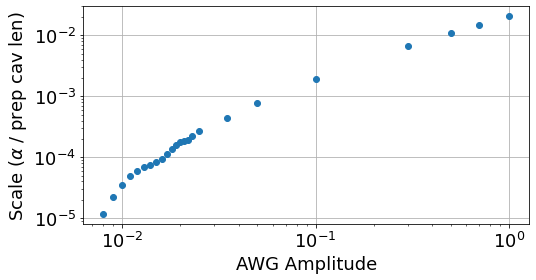

In [2]:
calib_file = "S:\\_Data\\200302 - 3DMM2 cooldown 10 - sideband with LO and mixer\\drive_calibrations\\00000_cavity_transfer_calibration_max0.5gauss_mode2.h5"

with File(calib_file,'r') as a:
        cal_alpha = array(a['omegas'])
        cal_amp = array(a['amps'])
cal_amp, cal_alpha = zip(*sorted(zip(list(cal_amp), list(cal_alpha))))

cal_amp = array(cal_amp)
cal_alpha = array(cal_alpha)
plt.figure(figsize=(8, 4))
plt.loglog(cal_amp, cal_alpha, 'o')
plt.xlabel("AWG Amplitude")
plt.ylabel('Scale ($\\alpha$ / prep cav len)')
plt.grid(minorticks_on)
plt.show()

In [3]:
(cal_alpha, cal_amp)

(array([1.17803991e-05, 2.21258135e-05, 3.51669644e-05, 4.85266208e-05,
        5.96339142e-05, 6.80087815e-05, 7.58334323e-05, 8.24075111e-05,
        9.43040972e-05, 1.14178204e-04, 1.37851353e-04, 1.58353026e-04,
        1.79658143e-04, 1.83590676e-04, 1.94772137e-04, 2.19378183e-04,
        2.72295822e-04, 4.43545482e-04, 7.89811460e-04, 1.94873008e-03,
        6.57846356e-03, 1.07617332e-02, 1.49736065e-02, 2.06619688e-02]),
 array([0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016,
        0.017, 0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.025, 0.035,
        0.05 , 0.1  , 0.3  , 0.5  , 0.7  , 1.   ]))

In [4]:
def amp_to_ncav(amp, length):
    """Given an AWG amplitude and length of the pulse, it outputs
        the expected number of photons in the storage cavity. 
    """
    m, b = 0.020142211114840426, 0.0006550610551433015 #fit parameters from the linear part
    calib_file = "S:\\_Data\\200302 - 3DMM2 cooldown 10 - sideband with LO and mixer\\drive_calibrations\\00000_cavity_transfer_calibration_max0.5gauss_mode2.h5"

    with File(calib_file,'r') as a:
        cal_alpha = array(a['omegas'])
        cal_amp = array(a['amps'])
    cal_amp, cal_alpha = zip(*sorted(zip(list(cal_amp), list(cal_alpha))))
    cal_amp = array(cal_amp)
    cal_alpha = array(cal_alpha)
    if amp > 0.05:
        v = m*amp+b
    elif amp == 0.0:
        v = 0.0
    else:
        u = np.argmin(abs(amp-cal_amp))
        v = cal_alpha[u]
    alpha = v*length
    return (alpha)**2*np.exp(-alpha**2)


def photon_counter_line(x, eff, err):
    #n = initial Fock state
    n = 1
    return eff*(n+1)*(np.array(x)) + err
#     return (n+1)*(eff*(np.array(x)) + err)

def ninj_to_nobs(nbar, n, l):
    if l>=n:
        return factorial(n)/(factorial(l)) * nbar**(l-n) * np.exp(-nbar) * (eval_genlaguerre(n, l-n, nbar))**2
    elif l<n:
        return factorial(l)/(factorial(n)) * nbar**(n-l) * np.exp(-nbar) * (eval_genlaguerre(l, n-l, nbar))**2
def fit_line(x, eff, err):
    n = 1
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    return eff*Pn_dn + err
    
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

n0_camp_0.0.h5
n0_camp_0.008.h5
n0_camp_0.009.h5
n0_camp_0.01.h5
n0_camp_0.011.h5
n0_camp_0.012.h5
n0_camp_0.013.h5
n0_camp_0.015.h5
n0_camp_0.018.h5
n0_camp_0.02.h5
n0_camp_0.025.h5
n0_camp_0.035.h5
n0_camp_0.05.h5
n0_camp_0.08.h5
n0_camp_0.1.h5


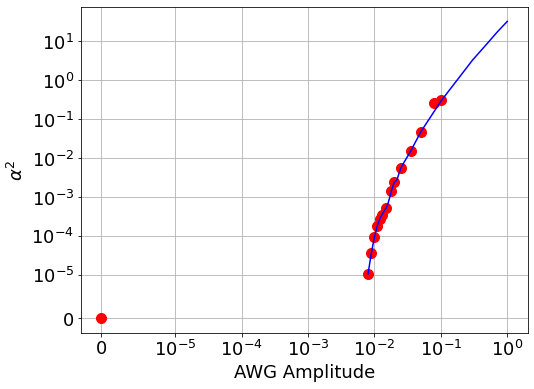

In [31]:
data_path =  "../data/g0_nopiat0/injected_photon/"
filenames_like = os.listdir(data_path)

amps = []
n_exp = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as f:
        a = (array(f['cav_amp']))
        l = (array(f['length']))
        f.close()
    amps.append(a)
    n_exp.append(amp_to_ncav(a, l))
amps = sorted(array(amps))
n_exp = sorted(array(n_exp))

plt.figure(figsize=(8, 6))
plt.loglog(sorted(amps), n_exp, 'ro', markersize=10)
plt.loglog(cal_amp, (cal_alpha*275)**2, 'b')
plt.yscale('symlog', linthreshy=1e-5)
plt.xscale('symlog', linthreshx=1e-5)
plt.ylabel(r'$\alpha^{2}$')
plt.xlabel("AWG Amplitude")
plt.grid(minorticks_on)
plt.show()

## Computing the error probabilities

In [32]:
th_m = np.logspace(2, 14, 13)
th_n = 1e3
th_n_exp = (1-np.exp(-1*10/1500))
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_m_oct = array(a['p_m_oct'])
        a.close()
        detect = []
        detect_err = []
        detect_err_bi = []
    for th in th_m:
        count_m = 0
        for ii, p in enumerate(p_m_oct):
            if p> th:
                count_m+=1
        t = count_m/len(p_m_oct)
        detect.append(t)
        detect_err.append(np.sqrt(count_m)/len(p_m_oct))
        detect_err_bi.append(np.sqrt(t*(1-t)/len(p_m_oct)))
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n+1}$"%(len(p_m_oct), count_m))
    detected_th[n_exp[jj]] = detect
    detected_th_err[n_exp[jj]] = detect_err
    detected_th_err_bi[n_exp[jj]] = detect_err_bi

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
yerr_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)

n0_camp_0.0.h5
Total number of events collected: 20000, 6 events crossed $\lambda_{th, n+1}$
n0_camp_0.008.h5
Total number of events collected: 24000, 4 events crossed $\lambda_{th, n+1}$
n0_camp_0.009.h5
Total number of events collected: 22000, 2 events crossed $\lambda_{th, n+1}$
n0_camp_0.01.h5
Total number of events collected: 10000, 4 events crossed $\lambda_{th, n+1}$
n0_camp_0.011.h5
Total number of events collected: 6000, 1 events crossed $\lambda_{th, n+1}$
n0_camp_0.012.h5
Total number of events collected: 6000, 1 events crossed $\lambda_{th, n+1}$
n0_camp_0.013.h5
Total number of events collected: 6000, 3 events crossed $\lambda_{th, n+1}$
n0_camp_0.015.h5
Total number of events collected: 6000, 3 events crossed $\lambda_{th, n+1}$
n0_camp_0.018.h5
Total number of events collected: 2000, 2 events crossed $\lambda_{th, n+1}$
n0_camp_0.02.h5
Total number of events collected: 2000, 2 events crossed $\lambda_{th, n+1}$
n0_camp_0.025.h5
Total number of events collected: 2000, 3 e

In [33]:
det_eff = []
det_darkcount = []
eff_corr_darkcount = []
for ii in range(len(th_m)):
    popt, pcov = curve_fit(f=fit_line, xdata=n_exp, ydata=y.iloc[ii], sigma=yerr.iloc[ii], 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


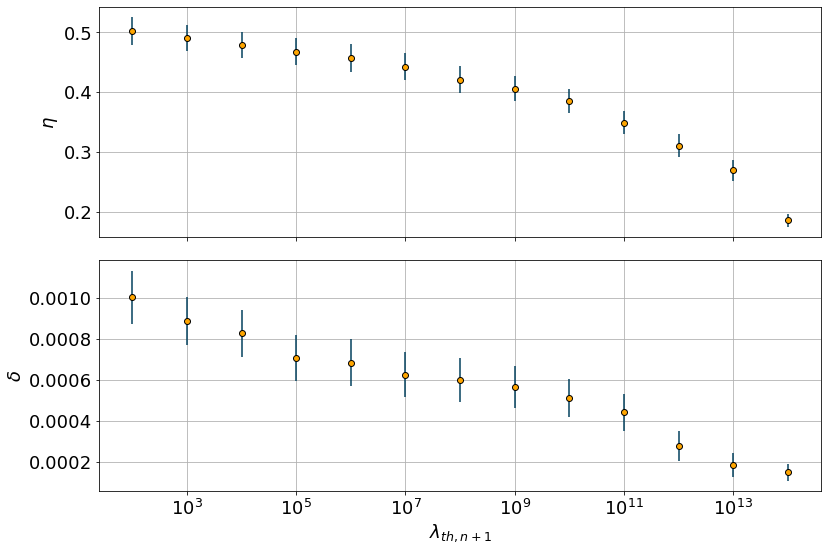

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8),sharex=True)
ax1.errorbar(x= th_m, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)

# ax1.set_yscale('log')
ax2.errorbar(x= th_m, y= pd.DataFrame(det_darkcount)[0], yerr= pd.DataFrame(det_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
# ax2.errorbar(x= th_m, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
#              fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
# ax2.errorbar(x= th_m, y= pd.DataFrame(det_darkcount)[0], yerr= pd.DataFrame(det_darkcount)[1],
#              fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
# ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_ylabel(r'$\delta$')
ax2.set_xlabel(r'$\lambda_{th, n+1}$')
# ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

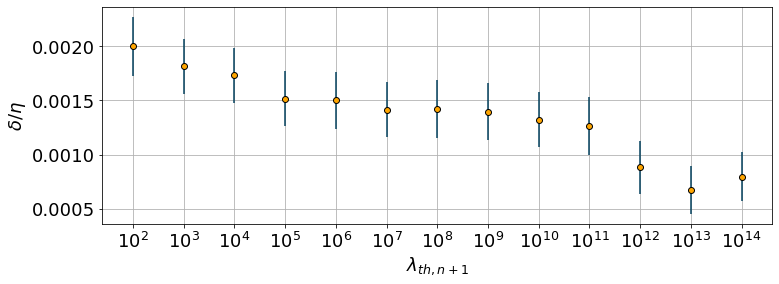

In [36]:
delta_n = pd.DataFrame(det_darkcount)[0]/pd.DataFrame(det_eff)[0]
plt.figure(figsize=(12, 4))
plt.errorbar(th_m, y=pd.DataFrame(eff_corr_darkcount)[0], yerr=pd.DataFrame(eff_corr_darkcount)[1], 
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
plt.ylabel(r'$\delta/\eta$')
plt.xlabel(r'$\lambda_{th, n+1}$')
plt.xscale('symlog', linthreshx=1e-5)
# plt.yscale('log')
plt.grid(minorticks_on)
plt.show()

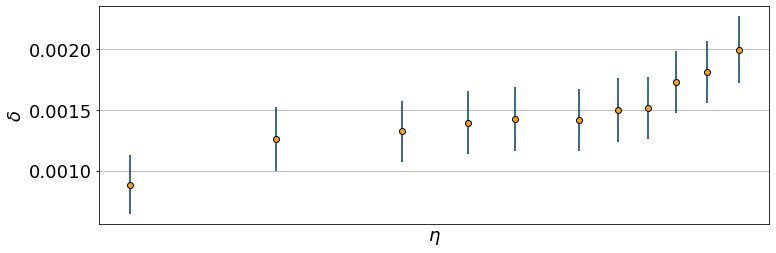

In [30]:
delta_n = pd.DataFrame(det_darkcount)[0]/pd.DataFrame(det_eff)[0]
plt.figure(figsize=(12, 4))
plt.errorbar(pd.DataFrame(det_eff)[0], y=pd.DataFrame(eff_corr_darkcount)[0], yerr=pd.DataFrame(eff_corr_darkcount)[1], 
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
plt.ylabel(r'$\delta$')
plt.xlabel(r'$\eta$')
plt.xscale('symlog', linthreshx=1e-5)
# plt.yscale('log')
plt.grid(minorticks_on)
plt.show()

In [21]:
pd.DataFrame(eff_corr_darkcount)[0]

0     0.001998
1     0.001814
2     0.001732
3     0.001515
4     0.001500
5     0.001414
6     0.001423
7     0.001396
8     0.001323
9     0.001263
10    0.000885
Name: 0, dtype: float64

## Fit

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


[0.47069545 0.00070639]


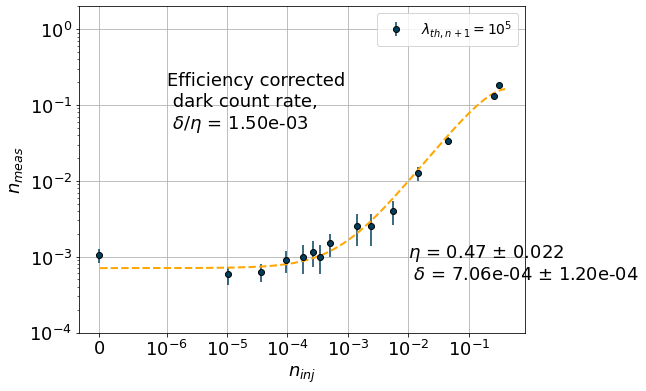

In [39]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 10
plt.figure(figsize=(8, 6))
# plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th, n+1} =  10^{%.f}$'%(np.log10(th_m[-m])))

popt, pcov = curve_fit(f=fit_line, xdata=n_exp, ydata=y.iloc[-m], sigma=yerr_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
print(popt)
# plt.plot(n_exp, fit_line(n_exp, *popt), linewidth=2, linestyle='--', color='#ffa600')
x = np.linspace(1e-8, 4e-1, 100001)
h = fit_line(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthreshx=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-4, 2e0)
plt.text(1e-2, 5e-4, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n $\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(1e-6, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e}'.format(popt[1]/(popt[0])))
# plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1)) 
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
plt.show()

## Cavity temp

In [40]:
w = 2*np.pi*5.97*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/1.50e-3))
print(T)

0.044063691223350486


In [212]:
w = 2*np.pi*5.97*1e9
T = 40e-3
np.exp(-hbar*w/(k*T))

0.0007748255440902217